In [1]:
## Load in libraries ##
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
from sklearn import tree
from sklearn.cross_validation import train_test_split
%matplotlib inline
import math
from scipy import stats
from sklearn.utils.multiclass import type_of_target

C:\Users\qiuyuwei\AppData\Local\Continuum\anaconda2\lib\site-packages\sklearn\cross_validation.py:41: DeprecationWarning: This module was deprecated in version 0.18 in favor of the model_selection module into which all the refactored classes and functions are moved. Also note that the interface of the new CV iterators are different from that of this module. This module will be removed in 0.20.
  "This module will be removed in 0.20.", DeprecationWarning)


In [2]:
## read data ##
TestData = pd.read_csv(r'C:\Users\qiuyuwei\Documents\Data\testTC.csv', header=0, index_col=0)
TestData.head()

,operator,behavior,score,level,repay,credit,social,bad
no,,,,,,,,
23,����,74.0,78.0,68.0,68.0,99.0,83.0,0
25,����,68.0,81.0,86.0,80.0,99.0,74.0,0
69,����,67.0,72.0,68.0,55.0,99.0,69.0,0
87,����,79.0,84.0,81.0,76.0,99.0,86.0,0
99,����,79.0,76.0,87.0,55.0,83.0,74.0,0


In [3]:
## coverage analysis ##
TestData.info()
print ("\n")
print (TestData.isnull().sum())
print ("\n")
print (1-TestData.isnull().sum().astype(float)/TestData.count()) # coverage rate

<class 'pandas.core.frame.DataFrame'>
Int64Index: 9999 entries, 23 to 9999
Data columns (total 8 columns):
operator    9999 non-null object
behavior    786 non-null float64
score       786 non-null float64
level       786 non-null float64
repay       786 non-null float64
credit      786 non-null float64
social      786 non-null float64
bad         9999 non-null int64
dtypes: float64(6), int64(1), object(1)
memory usage: 703.1+ KB


operator       0
behavior    9213
score       9213
level       9213
repay       9213
credit      9213
social      9213
bad            0
dtype: int64


operator     1.000000
behavior   -10.721374
score      -10.721374
level      -10.721374
repay      -10.721374
credit     -10.721374
social     -10.721374
bad          1.000000
dtype: float64


In [4]:
## deal with null values ##
TestData.fillna(-1,inplace=True)

In [12]:
TestData['score'].max()

86.0

In [10]:
TestData = TestData[TestData.score!=-1]

C:\Users\qiuyuwei\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:6: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  
C:\Users\qiuyuwei\AppData\Local\Continuum\anaconda2\lib\site-packages\ipykernel_launcher.py:15: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  from ipykernel import kernelapp as app


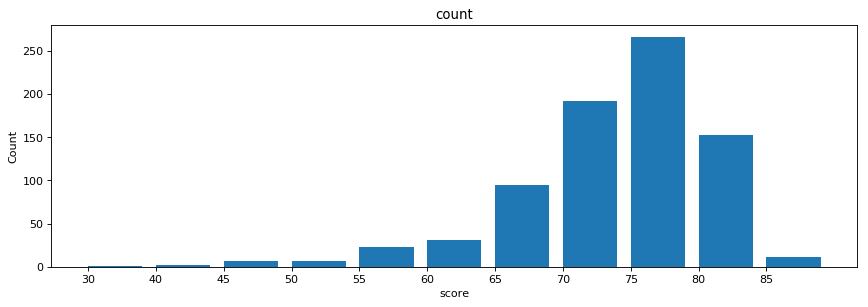

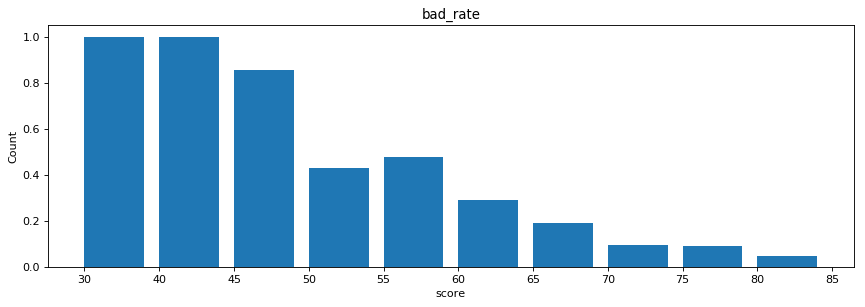

In [13]:
## general view ##

feature = 'score' # select a feature-----------!

# 区间统计 
TestData['Itvl'] = 0
'''    
# 等分feature为n个区间 
Itvl_n = 10 # assign the number of intervals-----------!
TestData['Itvl'] = pd.cut(TestData[feature], Itvl_n)
'''
# 根据需求指定feature分类区间 -----------!
for ii in range(30,90,5): # change the interval here-------!
    indexx = filter(lambda x : TestData[feature].iloc[x]>=ii and TestData[feature].iloc[x]<ii+5, range(TestData.bad.count()))
    TestData['Itvl'].iloc[indexx] = ii
#'''

# 定义聚合函数 
def get_stats(group): 
    return {'count': group.count()} 

# 分组统计 
grouped =TestData.bad.groupby(TestData['Itvl']) #总样本数
bucket_count = grouped.apply(get_stats).unstack() 
 
group2 =TestData[TestData.bad==1]['bad'].groupby(TestData[TestData.bad==1]['Itvl']) #bad样本数
temp = group2.apply(get_stats).unstack()

bucket_count = bucket_count.assign(bad=temp)

bucket_count['bad_rate'] = 0
bucket_count['bad_rate'] = bucket_count['bad']/bucket_count['count']
    
# 绘制柱状图
def drawBar(xx):
    xticks = list(xx.index)
    
    #自定义画布大小
    plt.figure(figsize=(13,4),dpi=80)
    
    #创建柱状图
    #第一个参数为柱的横坐标，第二个参数为柱的高度
    #参数align为柱的对齐方式，以第一个参数为参考标准
    plt.bar(range(len(xticks)), [xx.loc[xtick] for xtick in xticks], align='edge') #align='center'


    #设置柱的文字说明
    #第一个参数为文字说明的横坐标
    #第二个参数为文字说明的内容
    plt.xticks(range(len(xticks)), xticks)

    #设置横坐标的文字说明
    plt.xlabel(feature)
    #设置纵坐标的文字说明
    plt.ylabel('Count')
    #设置标题
    plt.title(xx.name)
    #绘图
    plt.show()

#drawBar(bucket_count['count'])
#drawBar(bucket_count['bad_rate'])

# 双纵坐标绘图函数
def drawBarLine(data1, data2):
    
    #自定义画布大小
    fig = plt.figure(figsize=(13,4),dpi=80)
    
    ax1 = fig.subplots()

    xticks = list(data1.index)
    ax1.bar(xticks, [data1.loc[xtick] for xtick in xticks], align='edge' ,width = 3)
    #设置横坐标的文字说明
    ax1.set_xlabel(feature)
    #设置ax1纵坐标的文字说明
    ax1.set_ylabel(data1.name)

    ax2 = ax1.twinx() # 两个绘图对象共享横坐标轴
    ax2.plot(xticks, [data2.loc[xtick] for xtick in xticks], 'k')
    #设置ax2纵坐标的文字说明
    ax2.set_ylabel(data2.name)
    # 右侧ax2坐标y轴可见
    ax2.spines['right'].set_visible(True)

# 调用绘图函数
drawBarLine(bucket_count['count'], bucket_count['bad_rate'])

In [25]:
## Cutoff- Precision and Recall ##
# and KS
cutoff = 75 # adjust the cutoff value----------!

Slt = TestData[TestData[feature]<cutoff].count()[0]

goodSmpl = TestData[TestData.bad==0].count()[0]
goodHit = TestData[(TestData["bad"]==0) & (TestData[feature]<cutoff)].count()[0]

badSmpl = TestData[TestData.bad==1].count()[0] 
badHit = TestData[(TestData["bad"]==1) & (TestData[feature]<cutoff)].count()[0]

precision = float(badHit)/float(Slt)
recall = float(badHit)/float(badSmpl)
KS = recall-float(goodHit)/float(goodSmpl)

print ("badSample: %d" % badSmpl)
print ("goodSample: %d" % goodSmpl)
print ("selected: %d" % Slt)
print ("Hit: %d" % badHit)
print ("precision: %f" % precision) 
print ("recall: %f" % recall) 
print ("KS value: %f" % KS) 

badSample: 99
goodSample: 687
selected: 357
Hit: 68
precision: 0.190476
recall: 0.686869
KS value: 0.266199


In [59]:
## WOE & IV ##

class WOE:
    def __init__(self):
        self._WOE_MIN = -20
        self._WOE_MAX = 20


    def woe(self, X, y, event=1):
        '''
        Calculate woe of each feature category and information value
        :param X: 2-D numpy array explanatory features which should be discreted already
        :param y: 1-D numpy array target variable which should be binary
        :param event: value of binary stands for the event to predict
        :return: numpy array of woe dictionaries, each dictionary contains woe values for categories of each feature
                 numpy array of information value of each feature
        '''
        self.check_target_binary(y)
        X1 = self.feature_discretion(X)

        res_woe = []
        res_iv = []

        for i in range(0, X1.shape[-1]):
            x = X1[:, i]
            woe_dict, iv1 = self.woe_single_x(x, y, event)
            res_woe.append(woe_dict)
            res_iv.append(iv1)
        return np.array(res_woe), np.array(res_iv)


    def woe_single_x(self, x, y, event=1):
        '''
        calculate woe and information for a single feature
        :param x: 1-D numpy starnds for single feature
        :param y: 1-D numpy array target variable
        :param event: value of binary stands for the event to predict
        :return: dictionary contains woe values for categories of this feature
                 information value of this feature
        '''
        self.check_target_binary(y)

        event_total, non_event_total = self.count_binary(y, event=event)
        x_labels = np.unique(x)
        woe_dict = {}

        iv = 0

        for x1 in x_labels:
            y1 = y[np.where(x == x1)[0]]
            event_count, non_event_count = self.count_binary(y1, event=event)
            rate_event = 1.0 * event_count / event_total
            rate_non_event = 1.0 * non_event_count / non_event_total
            if rate_event == 0:
                woe1 = self._WOE_MIN
            elif rate_non_event == 0:
                woe1 = self._WOE_MAX
            else:
                woe1 = math.log(rate_event / rate_non_event)
            woe_dict[x1] = woe1
            iv += (rate_event - rate_non_event) * woe1
        return woe_dict, iv


    def combine(self, list):
        res = ''
        for item in list:
            res += str(item)
        return res


    def count_binary(self, a, event=1):
        event_count = (a == event).sum()
        non_event_count = a.shape[-1] - event_count
        return event_count, non_event_count


    def check_target_binary(self, y):
        '''
        check if the target variable is binary, raise error if not.
        :param y:
        :return:
        '''
        y_type = type_of_target(y)
        if y_type not in ['binary']:
            raise ValueError('Label type must be binary')


    def feature_discretion(self, X):
        '''
        Discrete the continuous features of input data X, and keep other features unchanged.
        :param X : numpy array
        :return: the numpy array in which all continuous features are discreted
        '''
        temp = []

        for i in range(0, X.shape[-1]):
            x = X[:, i]
            x_type = type_of_target(x)
            if x_type == 'continuous':
                x1 = self.discrete(x)
                temp.append(x1)
            else:
                temp.append(x)
        return np.array(temp).T
    

    def discrete(self, x):
        '''
        Discrete the input 1-D numpy array using 5 equal percentiles
        :param x: 1-D numpy array
        :return: discreted 1-D numpy array
        '''
        res = np.array([0] * x.shape[-1], dtype=int)
        
        for i in range(5):
            point1 = stats.scoreatpercentile(x, i * 20)
            point2 = stats.scoreatpercentile(x, (i + 1) * 20)
            x1 = x[np.where((x >= point1) & (x <= point2))]
            mask = np.in1d(x, x1)
            res[mask] = (i + 1)
        return res

    @property
    def WOE_MIN(self):
        return self._WOE_MIN

    @WOE_MIN.setter
    def WOE_MIN(self, woe_min):
        self._WOE_MIN = woe_min

    @property
    def WOE_MAX(self):
        return self._WOE_MAX

    @WOE_MAX.setter
    def WOE_MAX(self, woe_max):
        self._WOE_MAX = woe_max
        

obj = WOE()
predictors = ['score','blacklist','deduct_failure','overdue_order','repay_old','debt_instit','debt_together'] # feature------!
rslt = obj.woe(np.array(TestData[predictors]),np.array(TestData['bad']))

print rslt[1]

[ 3.35364866  0.73852351  1.64505833  0.19399822  0.21900683  0.16745506
  0.62664123]


In [73]:
## build a DecisionTreeClassifier ##
target = 'bad' # tag-----------!
predictors = ['score','blacklist','deduct_failure','overdue_order','debt_together'] # feature-----------!

train, test = train_test_split(TestData, train_size=0.75, random_state=1)

clf = tree.DecisionTreeClassifier(max_depth=3)
clf = clf.fit(train[predictors], train[target])

train_predictions = clf.predict(train[predictors])
test_predictions = clf.predict(test[predictors])
#train_predprob = clf.predict_proba(train[predictors])[:,1]
#test_predprob = clf.predict_proba(test[predictors])[:,1]

train = train.assign(predict=train_predictions)
test = test.assign(predict=test_predictions)

In [74]:
# Print model report(Train):
bSample = train[train.bad==1].count()[0]
bHit = train[(train["bad"]==1) & (train["predict"]==1)].count()[0]

gSample = train[train.bad==0].count()[0]
gHit = train[(train["bad"]==0) & (train["predict"]==1)].count()[0]

KS_m = float(bHit)/float(bSample)-float(gHit)/float(gSample)

print ("\nModel Report")
print ("Bad Sample (Train): %d" % bSample)
print ("Bad Hit (Train): %d" % bHit)
print ("Good Sample (Train): %d" % gSample)
print ("Good Hit (Train): %d" % gHit)
print ("KS (Train): %f" % KS_m)
print ("\n")

#Print model report(Test):
bSample_tst = test[test.bad==1].count()[0]
bHit_tst = test[(test["bad"]==1) & (test["predict"]==1)].count()[0]

gSample_tst = test[test.bad==0].count()[0]
gHit_tst = test[(test["bad"]==0) & (test["predict"]==1)].count()[0]

KS_m_tst = float(bHit_tst)/float(bSample_tst)-float(gHit_tst)/float(gSample_tst)

print ("Bad Sample (Test): %d" % bSample_tst)
print ("Bad Hit (Test): %d" % bHit_tst)
print ("Good Sample (Test): %d" % gSample_tst)
print ("Good Hit (Test): %d" % gHit_tst)
print ("KS (Test): %f" % KS_m_tst)


Model Report
Bad Sample (Train): 3772
Bad Hit (Train): 2736
Good Sample (Train): 3740
Good Hit (Train): 533
KS (Train): 0.582831


Bad Sample (Test): 1236
Bad Hit (Test): 859
Good Sample (Test): 1268
Good Hit (Test): 167
KS (Test): 0.563280


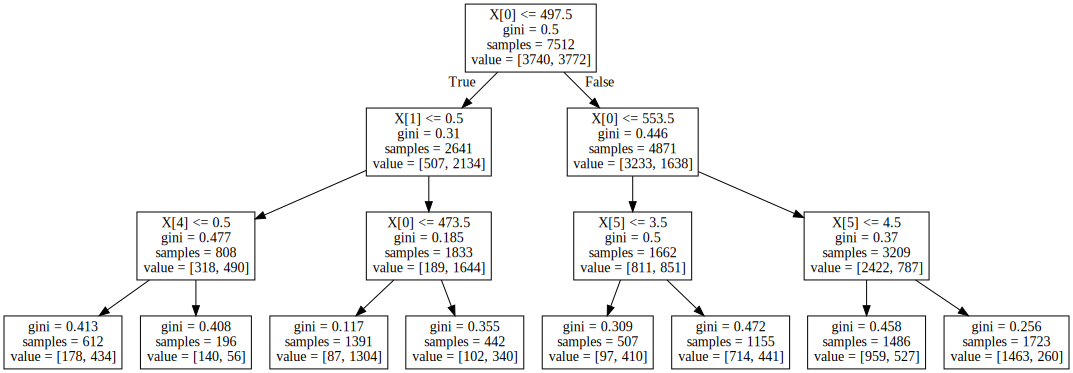

In [115]:
# show the classification tree
import graphviz 
dot_data = tree.export_graphviz(clf, out_file=None) 
graph = graphviz.Source(dot_data) 
#graph.render("TianyuTest") 
graph

In [ ]:
## wrtie to csv file ##
#cols = [x for x in train.columns if x not in ['bad','name']]
#TestData.to_csv(r'C:\Users\qiuyuwei\Documents\Xinyan_testResult.csv', columns = cols)